# Tuning In: COVID-19 Vaccine Discourse on Public Radio in South Africa and Nigeria

Supplementary code for 2021 Social Data Science (SDS) MSc thesis.


## Import Libraries

In [70]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
# Python libraries
import os
import ast
from collections import Counter, defaultdict
import collections
from datetime import datetime, timedelta
import random
import re

# Data science libraries
import numpy as np
import pandas as pd
# Suppress pandas warning
pd.options.mode.chained_assignment = None  # default='warn'

# Plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
import matplotlib.font_manager

# styling figures
# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = 'Palatino'
# sns.set()
# sns.set_style("white")

from adjustText import adjust_text

import matplotlib.pyplot as plt
plt.style.reload_library()
plt.style.use('science')

# Set color palette to ORCA palette
from cycler import cycler
import matplotlib as mpl
mpl.rcParams['axes.prop_cycle'] = cycler(color=['#68829D', '#329B8A', '#D24437', '#F5B100', '#62ABB9', '#A3B100'])

In [72]:
# some global variables
WEEK_NAMES = [f"w{i}" for i in range(8)]
WEEK_NAMES_SPLITS = [(a,b) for a,b in zip(WEEK_NAMES[:-1], WEEK_NAMES[1:])]
SUNDAYS = ['2021-02-21', '2021-02-28', '2021-03-07', '2021-03-14', '2021-03-21',
            '2021-03-28', '2021-04-04', '2021-04-11', '2021-04-18']
WEEK_SPLITS = [(a,b) for a, b in zip(SUNDAYS[:-1], SUNDAYS[1:])]
COUNTRIES = ["south_africa", "nigeria"]

# Formatting labels for the figures
prettify_vaccine = {
    "astrazeneca": "AZ",
    "johnson_johnson": "J&J",
    "covax": "COVAX",
    "pfizer": "Pfizer"
}

prettify_country = {
    "south_africa": "South Africa",
    "nigeria": "Nigeria"
}

In [73]:
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

def get_cosine_similarity(feature_vec_1, feature_vec_2):    
    return cosine_similarity(feature_vec_1.reshape(1, -1), feature_vec_2.reshape(1, -1))[0][0]

def jaccard_score(list1, list2, k):
    """
        Jaccard similarity
    """
    list1 = [x for x in list1[0:k]]
    list2 = [x for x in list2[0:k]]
    s1 = set(list1)
    s2 = set(list2)
    jaccard = float(len(s1.intersection(s2)) / len(s1.union(s2)))
    return jaccard 

# Data Pre-processing
Clean up the raw radio transcriptions

In [5]:
import string
import nltk
from nltk.tokenize import word_tokenize

# Import NLTK's stop words
from nltk.corpus import stopwords 
STOP_WORDS = set(stopwords.words('english')) 
# Supplement stop words using radio-specific words
STOP_WORDS.update(["um", "uh", "huh", "mhm", "yeah", "ah", "oh", "dot", "okay", "mm", "blah"])

# Import SpaCy's lemmatizer
import spacy
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

ModuleNotFoundError: No module named 'thinc.api'

In [ ]:
def extract_radio_station_from_filename(filename):
    """Extracts radio station name from the filename"""
    return re.search('\w+-\w+-\d\d\d\d-\d\d-\d\d-(\w+)_', filename).group(1)

def extract_country_from_station(station):
    """For a given station, matches the corresponding country"""
    SA = ['Cape Town', 'Johannesburg', 'Durban']
    NI = ['Lagos', 'Ibadan']
    if station in SA:
        return ('South Africa')
    elif station in NI:
        return('Nigeria')
    
def clean_transcriptions(t):
    """
        Cleans transcriptions by removing punctuation and digits, lowercasing,
        and replacing common misspellings or mis-transcriptions of COVID related
        words (astrazeneca, johnson, covax). Further, it combines certain
        tokens into one phrase (i.e., blood clot -> blood_clot)
        
        Note: This returns a string, not tokenized
    """
    text = str(t)
    
    # Lowercase
    text = text.lower()
    # Keep all alphanumeric characters (including digits)
    text = re.sub(r'[^\w\s]','',text)
    # Remove digits, keep only alphabet characters
    text = re.sub(r'\w*\d+\w*', '', text)
    # Remove multiple spaces in a row with one space
    text = re.sub(r'\s\s+', ' ', text)
    
    # Tokenize Johnson and Johnson and its variations
    text = re.sub(r'(johnson and johnson)|jnj', 'johnson_johnson', text)
    # Tokenize astrazeneca and its variations
    text = re.sub(r'(astra zeneca)|astrazenecas', 'astrazeneca', text)
    # Tokenize COVAX and its variations
    text = re.sub(r'corvex|kovacs|kovac', 'covax', text)
    # A mistake in the transcription
    text = re.sub(r'gon na', 'gonna', text)
    
    # Pre-doing some bad lemma things
    text = re.sub(r'suspension|suspending', 'suspend', text)
    text = re.sub(r'pausing', 'pause', text)
    text = re.sub(r'vaccination', 'vaccinate', text)
    text = re.sub(r'inoculation', 'inoculate', text)
    text = re.sub(r'pregnancy', 'pregnant', text)
    text = re.sub(r'miscarry', 'miscarriage', text)
    text = re.sub(r'vomiting', 'vomit', text)
    text = re.sub(r'nauseous', 'nausea', text)
    text = re.sub(r'received|receiving', 'receive', text)
    text = re.sub(r'inequitable', 'inequity', text)

    return text

def lemmatize_pipe(doc):
    """Lemmatizes a given list. Additionally removes stop words"""
    lemma_list = [str(tok.lemma_).lower() for tok in doc
                  if tok.text.lower() not in STOP_WORDS] 
    return lemma_list

def preprocess_pipe(texts):
    """
        Using SpaCy pipeline to be faster at lemmatizing a lot of texts
        Code from: https://prrao87.github.io/blog/spacy/nlp/performance/2020/05/02/spacy-multiprocess.html
    """
    preproc_pipe = []
    for doc in nlp.pipe(texts, batch_size=20):
        preproc_pipe.append(lemmatize_pipe(doc))
    return preproc_pipe

In [6]:
# Read in the raw transcriptions and use only the relevant columns
df = pd.read_csv("data/raw_transcriptions.csv")
df = df[["filename", "transcription"]]

# Extract radio station from file name
df["radio_station"] = df['filename'].apply(extract_radio_station_from_filename)
# Extract country from file name
df["country"] = df["radio_station"].apply(extract_country_from_station)

# Remove null transcriptions
df = df[df.transcription.notna()]

# Assign week names for each date
for i, (start_date, end_date) in enumerate(WEEK_SPLITS):
    df.loc[df.date.apply(lambda x: (x >= start_date) & (x < end_date)), "week"] = f"w{i}"

FileNotFoundError: [Errno 2] No such file or directory: 'data/raw_transcriptions.csv'

In [663]:
df[["filename", "date", "week", "radio_station", "country", "transcription"]].sample(5)

,filename,date,week,radio_station,country,transcription
44054,who-0002-lagos-2021-04-03-LagosTalks_2021-04-0...,2021-04-03,w5,LagosTalks,Nigeria,a bank that is also interested in helping you ...
50909,who-0004-lagos-2021-04-11-LagosTalks_2021-04-1...,2021-04-11,w7,LagosTalks,Nigeria,I'm gonna get some good food in my body. I'm a...
16820,who4-johannesburg-2021-03-07-702Talk_2021-03-0...,2021-03-07,w2,702Talk,South Africa,"because human beings, we rely on our social ne..."
44265,who-0003-cape_town-2021-04-04-CapeTalk_2021-04...,2021-04-04,w6,CapeTalk,South Africa,the trailing trialing rather a scheme where pa...
20481,who8-johannesburg-2021-03-10-702Talk_2021-03-1...,2021-03-10,w2,702Talk,South Africa,Chester Book Academy preschool is ready to wel...


In [664]:
# Clean the transcription by replacing (it is still a string) 
df["clean_transcription"] = df.transcription.apply(clean_transcriptions)

# Lemmatize! (this takes a long time) (but it's worth it bc it's better than nltk)
df["tokens"] = preprocess_pipe(df.clean_transcription)

df.to_csv("data/transcriptions_df.csv", index=False)

In [665]:
# A mapping of week to dates
week_df = []
for i, (start_date, end_date) in enumerate(WEEK_SPLITS):
    week_df.append({"week": f"w{i}", "start": start_date, "end": end_date})
week_df = pd.DataFrame(week_df)

week_df

,week,start,end
0,w0,2021-02-21,2021-02-28
1,w1,2021-02-28,2021-03-07
2,w2,2021-03-07,2021-03-14
3,w3,2021-03-14,2021-03-21
4,w4,2021-03-21,2021-03-28
5,w5,2021-03-28,2021-04-04
6,w6,2021-04-04,2021-04-11
7,w7,2021-04-11,2021-04-18


In [4880]:
# What are the top words?
total_words = [a for sublist in df.tokens for a in sublist]
total_words_counter = Counter(total_words)

# Remove the top 20 words
most_frequent_words = [w for w,c in total_words_counter.most_common(20)]

# Remove words mentioned 5 or fewer times in the corpus
infrequent_words = [w for w,c in total_words_counter.most_common() if c < 10]

# Remove one-letter words
one_letter_words = [w for w,c in total_words_counter.most_common() if len(w) == 1]

# Words to remove
words_to_remove = most_frequent_words + one_letter_words
# Making it a set makes the lookup way faster
words_to_remove = set(words_to_remove)

In [4881]:
print(f"Out of originally {len(total_words_counter)} unique words, removing {len(words_to_remove)}")

Out of originally 80790 unique words, removing 42


In [4882]:
print(f"The top 20 words are: {most_frequent_words}")

The top 20 words are: ['know', 'go', 'nt', 'say', 'get', 'one', 'like', 'people', 'well', 'think', 'want', 'good', 'come', 'see', 'talk', 'right', 'time', 'make', 'take', 'thing']


In [4883]:
# Not removing them now bc they are removed during word emb training
df["tokens_proc"] = df.tokens.apply(lambda x: [word for word in x if word not in words_to_remove])

In [4322]:
# Save to csv
df.to_csv("data/transcriptions_df.csv", index=False)

# Post-processing Imports
Import the cleaned data for the rest of the analysis

In [75]:
# Read in the dataframe of cleaned transcriptions
df = pd.read_csv("transcriptions_df.csv")
df = df[df.clean_transcription.notna()]
df.tokens = df.tokens.apply(lambda x: ast.literal_eval(x))
df.tokens_proc = df.tokens_proc.apply(lambda x: ast.literal_eval(x))

df.date = pd.to_datetime(df.date)

south_africa = df[df.country=="South Africa"]
nigeria = df[df.country=="Nigeria"]

In [76]:
# All documents for each week and country (regardless of station)
TRAIN_POSTS = defaultdict()
# Vocabulary (set) for each week and country (regardless of station)
TRAIN_VOCAB = defaultdict()
# Counter for each vocabulary word for each week and country (regardless of station)
TRAIN_COUNTER = defaultdict()
# All documents for each DAY (regardless of station)
DAILY_DOCS = defaultdict()

ALL_DAYS = south_africa.date.unique()

for country, country_df in zip(COUNTRIES, [south_africa, nigeria]):
    print(country)
    DAILY_DOCS[country] = defaultdict(list)
    TRAIN_POSTS[country] = defaultdict(list)
    TRAIN_VOCAB[country] = defaultdict(list)
    TRAIN_COUNTER[country] = defaultdict(Counter)
    
    # Daily segments
    for date in ALL_DAYS:
        DAILY_DOCS[country][date] = [a for sublist in country_df[country_df.date==date].tokens_proc for a in sublist]
    
    # Weekly segments
    for week_name in WEEK_NAMES:
        data_split = country_df[country_df.week==week_name].tokens_proc
        TRAIN_POSTS[country][week_name] = data_split 
        
        week_vocab_counter = Counter([a for sublist in data_split for a in sublist])
        TRAIN_VOCAB[country][week_name] = [w for w,c in week_vocab_counter.most_common()]
        TRAIN_COUNTER[country][week_name] = week_vocab_counter
        
#         print(f"...len of data split for week {week_name}: {len(data_split)}, vocab: {len(week_vocab_counter)}")

south_africa
nigeria


In [180]:
'clot' in TRAIN_COUNTER["south_africa"]["w1"]

True

In [182]:
TRAIN_COUNTER["south_africa"]["w1"]["clot"], TRAIN_COUNTER["nigeria"]["w1"]["clot"],

(1, 0)

In [192]:
sa_w1 = south_africa[south_africa.week=="w0"]

# Frequency Plots

In [ ]:
plt.style.use('science')


In [77]:
# How many times is each vaccine word mentioned per day, per semantic space?

daily_counts = []
for word in ["astrazeneca", "johnson_johnson", "clot"]:
#     print(word)
    for country, country_df in zip(COUNTRIES, [south_africa, nigeria]):
        for date in ALL_DAYS:
            daily_counts.append({
                "word": word,
                "country": country,
                "date": date,
                "count": DAILY_DOCS[country][date].count(word),
                "total_words": len(DAILY_DOCS[country][date])
            })
            
vaccine_total_counts = pd.DataFrame(daily_counts)

# Normalized count
vaccine_total_counts["norm_count"] = vaccine_total_counts["count"]/vaccine_total_counts["total_words"]

In [78]:
nigeria_vaccine_counts = vaccine_total_counts[vaccine_total_counts.country=="nigeria"]
nigeria_vaccine_counts = pd.pivot_table(nigeria_vaccine_counts,
                  columns=["word"], index=["date"], values=["norm_count"])
nigeria_vaccine_counts = nigeria_vaccine_counts.rolling(7, min_periods=1, win_type='triang').sum()

southafrica_vaccine_counts = vaccine_total_counts[vaccine_total_counts.country=="south_africa"]
southafrica_vaccine_counts = pd.pivot_table(southafrica_vaccine_counts,
                  columns=["word"], index=["date"], values=["norm_count"])
southafrica_vaccine_counts = southafrica_vaccine_counts.rolling(7, min_periods=1, win_type='triang').sum()


In [95]:
vaccine_words = ["astrazeneca", "johnson_johnson", "clot"]
kwargs_axvline = {'linestyle':'dotted', 'color':'black'}
kwargs_text = {'color': '#696969', 'size':14, 'weight': 'medium'}

vac2word = {"astrazeneca": "AZ", "johnson_johnson": "J\&J", "clot": "clot"}

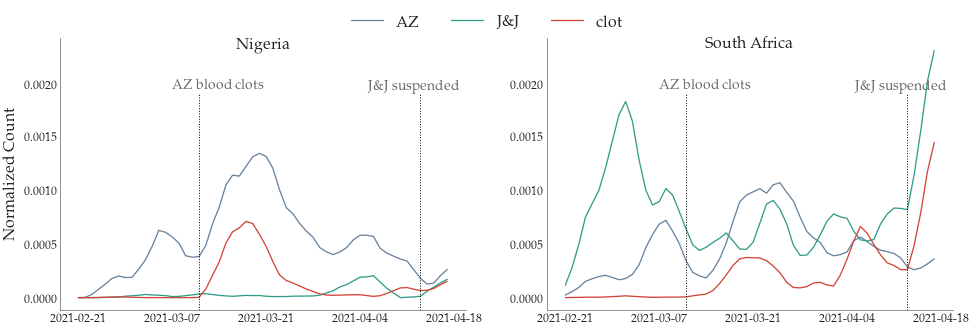

In [117]:
fig, axes = plt.subplots(1,2, figsize=(16,5))

# Share the same axis
axes[1].sharey(axes[0])


for ax, country_name, country_df in zip(axes, 
                                        ["Nigeria", "South Africa"], 
                                        [nigeria_vaccine_counts, southafrica_vaccine_counts]):
    
    # Plot the rolling average lines
    for vac in vaccine_words:  
        ax.plot(country_df.index.values, country_df[('norm_count', vac)], marker='', 
                  linewidth=1.3, label=vac2word[vac])
            
    # Remove all of the extra tick marks
    ax.minorticks_off()
    ax.tick_params(top=False, right=False)
    
    # AZ Blood clot event
    ax.axvline(x=datetime(2021, 3, 11), ymax=0.8, **kwargs_axvline)
    ax.text(x=datetime(2021, 3, 7), y=0.00195, s='AZ blood clots', **kwargs_text)
    
    # J&J Suspension event
    ax.axvline(x=datetime(2021, 4, 13), ymax=0.8, **kwargs_axvline)
    ax.text(x=datetime(2021, 4, 5), y=0.00195, s='J\&J suspended', **kwargs_text)

    # Set the title
    ax.set_title(country_name, y=0.94, size=16)
    
    # Set every other Sunday as a date
    ax.set_xticks(SUNDAYS[::2])
    
    # Set the tick labels to be larger
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)

    # Set the labels
    if country_name=="Nigeria":
        ax.set_ylabel('Normalized Count', size=16)
            
sns.despine(right=True, top=True)

lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, loc = 'upper center', ncol=3, fontsize=16)

# plt.show()
# plt.savefig('clot_freq_plot.pdf', bbox_inches='tight') 
plt.savefig('clot_freq_plot.png', bbox_inches='tight') 



In [84]:
df.groupby("country")["radio_station"].value_counts()

country       radio_station   
Nigeria       LagosTalks           9798
              FreshFM              8925
              NigeriaInfoLagos     4844
South Africa  702Talk             13890
              CapeTalk            13488
              VumaFM               5753
Name: radio_station, dtype: int64

# Word Embedding Models
Train models, calculate metrics from bootstrap models, then determine stability

## Train one model per country

In [131]:
from gensim.models import Word2Vec, KeyedVectors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [132]:
# TRAIN JUST ONE MODEL for each country, FOR BLOG POST
min_count=5
random_seed=42

SA_MODEL = Word2Vec(
    sentences = south_africa.tokens_proc,
    seed=random_seed,
    min_count=min_count
)

NI_MODEL = Word2Vec(
    sentences = nigeria.tokens_proc,
    seed=random_seed,
    min_count=min_count
)

In [133]:
model=SA_MODEL
X = np.array([model.wv[w] for w in words if w in model.wv])

NameError: name 'words' is not defined

In [91]:
def display_pca_scatterplot(model, words=None, sample=0, color='blue', random_state=42):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.wv.index_to_key), sample)
        else:
            words = [ word for word in model.wv ]
        
    word_vectors = np.array([model.wv[w] for w in words if w in model.wv])
    twodim = PCA(random_state=random_state).fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(8,8))
    plt.scatter(
        x=twodim[:,0], 
        y=twodim[:,1], 
        color='blue',
        s=100,
        alpha=0.5
    )

    together = []
    for word, (x,y) in zip(words, twodim):
        together.append((word, x, y))
    together.sort()

    text = [x for (x,y,z) in together]
    xs = [y for (x,y,z) in together]
    ys = [z for (x,y,z) in together]
    texts = []
    for x, y, word in zip(xs, ys, text):
        texts.append(plt.text(x, y, word, fontsize = 14))

    adjust_text(texts, x=xs, y=ys, autoalign='xy', only_move={'points':'y', 'text':'x'}, 
                arrowprops=dict(arrowstyle="-", color='black', lw=0.5),
                force_text=0.5,
    #             force_points=10,
               )

    sns.despine(top=True, bottom=True, left=True, right=True)

    plt.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False,  # labels along the bottom edge are off,
        labelleft=False
    ) 

    sns.set_style("dark")

In [92]:
words = ['covid', 'coronavirus', 'vaccine', 'astrazeneca', 'johnson_johnson',
         'pandemic', 'efficacy', 'rollout', 'blood', 'clot',
         'jab', 'administer', 'counterfeit', 'shipment'
        ]

words = ['covid', 'vaccine', 'astrazeneca', 'johnson_johnson',
         'pandemic', 'rollout', 'blood', 'clot', 'clotting',
         'shipment'
        ]

words = ['covid', 'coronavirus', 'vaccine', 'astrazeneca', 'johnson_johnson', 'pfizer', 'covax',
         'pandemic', 'rollout', 'clot', 'fever', 'headache',
         'shipment'
        ]

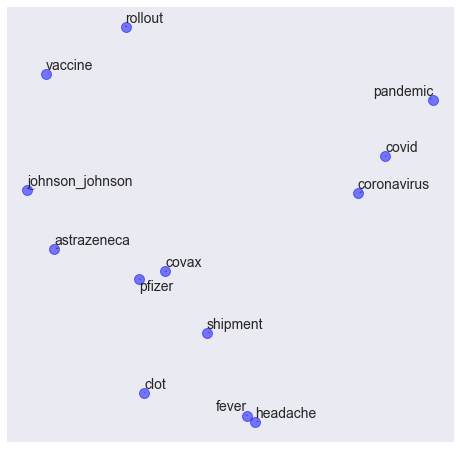

In [94]:
display_pca_scatterplot(SA_MODEL, words=words)
plt.savefig('img_blogpost/word_emb.png', bbox_inches='tight')


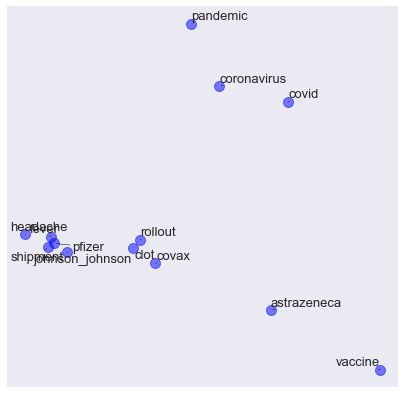

In [90]:
display_pca_scatterplot(NI_MODEL, words=words)

In [17]:
NI_MODEL.wv.most_similar('vaccine')

[('astrazeneca', 0.802428662776947),
 ('vaccinate', 0.8020437359809875),
 ('jab', 0.771670401096344),
 ('johnson_johnson', 0.7684541344642639),
 ('administer', 0.766767144203186),
 ('rollout', 0.7475446462631226),
 ('vaccinated', 0.7076324224472046),
 ('pfizer', 0.706409752368927),
 ('efficacy', 0.7038167119026184),
 ('batch', 0.7010331749916077)]

In [34]:
NI_MODEL.wv.most_similar('clot')

[('clotting', 0.7946299910545349),
 ('efficacy', 0.7540003657341003),
 ('jab', 0.7396807074546814),
 ('astrazeneca', 0.7157854437828064),
 ('blood', 0.7123333811759949),
 ('hiv', 0.7085408568382263),
 ('infection', 0.6987300515174866),
 ('infect', 0.6888006329536438),
 ('fungal', 0.6848281025886536),
 ('autoimmune', 0.68088698387146)]

### Topic Modeling

In [112]:
# https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

In [122]:
import gensim
from gensim import corpora, models
from gensim.parsing.preprocessing import preprocess_string, strip_punctuation, strip_numeric

filters = [lambda x: x.lower(), strip_punctuation, strip_numeric]


In [179]:
processed_docs = nigeria.tokens_proc

In [200]:
# Stuff with covid
processed_docs_covid = [a for a in processed_docs if 'vaccine' in a or 'vaccinate' in a or 'vaccines' in a]

In [201]:
len(processed_docs_covid), len(processed_docs)

(1434, 23568)

In [202]:
dictionary = gensim.corpora.Dictionary(processed_docs)

Filter out tokens that appear in
less than 5 documents (absolute number) or
more than 0.5 documents (fraction of total corpus size, not absolute number).
after the above two steps, keep only the first 100000 most frequent tokens.

In [203]:
dictionary.filter_extremes(no_below=5, keep_n=100000)

In [189]:
# bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [204]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [205]:
# Lda with tfidf
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)


In [206]:
# for idx, topic in lda_model.show_topics(num_topics=10, num_words=10, log=False, formatted=True):
#     print('Topic: {} \nWords: {}'.format(idx, topic))
    

for idx, topic in lda_model_tfidf.show_topics(num_topics=8, num_words=10, log=False, formatted=True):
    print(f"Topic {idx}", preprocess_string(topic, filters))

Topic 3 ['wait', 'baby', 'morning', 'nigeria', 'thank', 'woman', 'way', 'hello', 'love', 'game']
Topic 0 ['game', 'ball', 'goal', 'league', 'play', 'player', 'fidelity', 'manchester', 'chelsea', 'side']
Topic 8 ['morning', 'government', 'state', 'thank', 'nigeria', 'country', 'hello', 'president', 'governor', 'vaccine']
Topic 5 ['cook', 'money', 'way', 'bad', 'saving', 'wait', 'every', 'hello', 'nigeria', 'jazz']
Topic 4 ['lago', 'dish', 'woman', 'love', 'thank', 'conversation', 'relationship', 'god', 'guy', 'join']
Topic 9 ['love', 'nigeria', 'hello', 'paypal', 'cooperative', 'global', 'fresh', 'morning', 'thank', 'game']
Topic 1 ['fresh', 'hello', 'win', 'nigeria', 'fm', 'game', 'number', 'yes', 'plus', 'bank']
Topic 7 ['commando', 'sport', 'inside', 'drink', 'energy', 'super', 'heart', 'state', 'morning', 'nigeria']


### Word Clouds

In [ ]:
# Get the top xxx words
# Do a clustering (KNN) of them and find topics that way?
# Look at my old notebook



# OR
# For word cloud just make one

In [25]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from wordcloud import WordCloud, ImageColorGenerator
font_path = "/Library/Fonts/AmaticSC-Bold.ttf"


In [21]:
SA_COUNTER = Counter([a for sublist in south_africa.tokens_proc for a in sublist])
NI_COUNTER = Counter([a for sublist in nigeria.tokens_proc for a in sublist])

In [28]:
model = SA_MODEL

In [29]:
a = [w for w,v in model.wv.most_similar('covid', topn=100)]
b = [w for w,v in model.wv.most_similar('coronavirus', topn=100)]

In [34]:
len(set(a).union(set(b)))

138

In [110]:
def generate_word_clouds(model, counter, word='covid', topn=500, top_freq_words = []):
    nn_words = [w for w,v in model.wv.most_similar(word, topn=topn)]
#     coronavirus_nn = [w for w,v in model.wv.most_similar('coronavirus', topn=topn)]
    
    
#     nn_words = list(set(covid_nn).union(set(coronavirus_nn)))
    nn_words = [n for n in nn_words if n not in top_freq_words]
    
    X = np.array([model.wv[k] for k in nn_words])

    kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
    coms_kmeans = dict(defaultdict())

    for word, label in zip(nn_words, kmeans.labels_):
        if label in coms_kmeans:
            coms_kmeans[label].append(word)
        else:
            coms_kmeans[label] = [word]
    
    fig, axes = plt.subplots(2,2, figsize=(10,10))
    axes = [a for sublist in axes for a in sublist]

    for i in range(4):
        wordcloud = WordCloud(width = 3000, height = 2000,
                              background_color='black', colormap='Set2', font_path=font_path,)
        wordcloud.generate_from_frequencies(frequencies={n:SA_COUNTER[n] for n in coms_kmeans[i]} )
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].axis("off")

#     plt.suptitle(f'Word clouds clustering top {topn} nearest neighbors of covid')
    plt.tight_layout()
    
    
    return plt

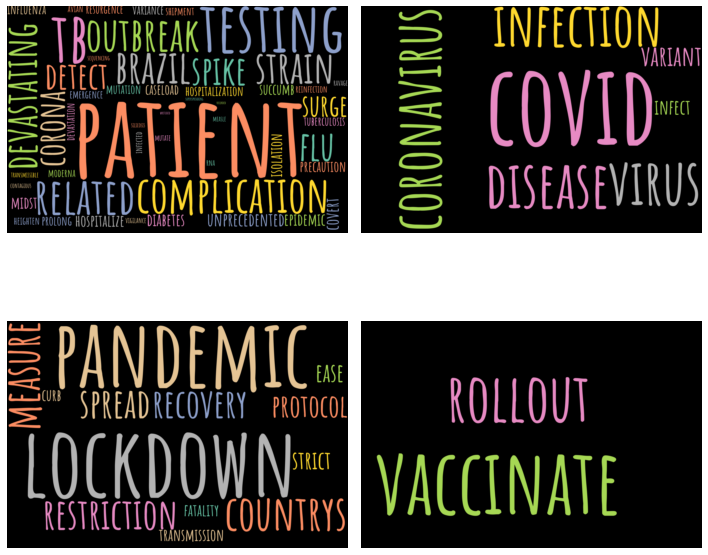

In [98]:
generate_word_clouds(SA_MODEL, SA_COUNTER, topn=50)

In [ ]:
nig_top_freq_words = [w for w,v in NI_COUNTER.most_common(50)]

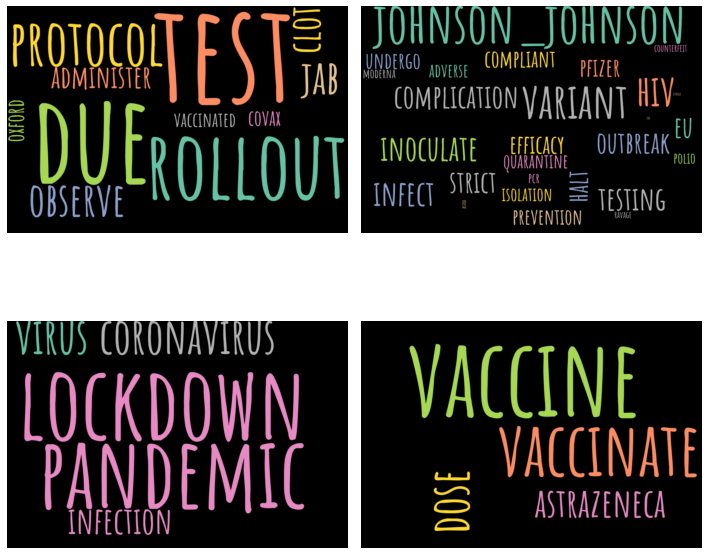

In [111]:
plt = generate_word_clouds(NI_MODEL, NI_COUNTER, topn=50, top_freq_words=nig_top_freq_words)
plt.savefig('img_blogpost/word_cloud_nigeria.png', bbox_inches='tight')


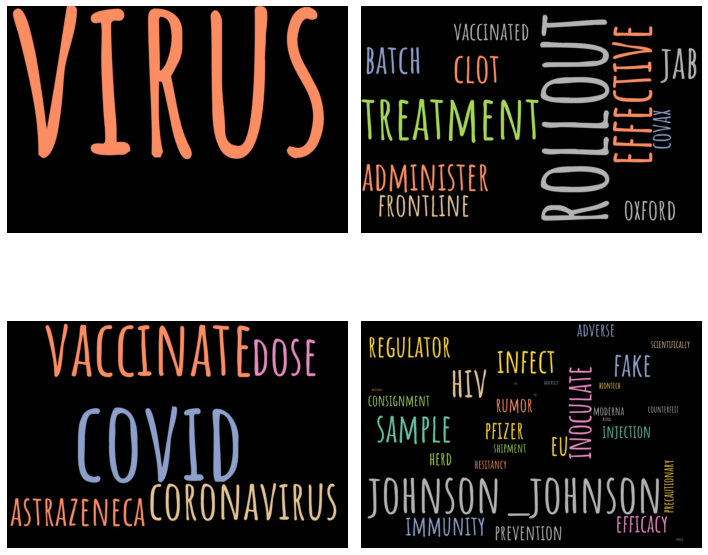

In [105]:
generate_word_clouds(NI_MODEL, NI_COUNTER, topn=50, word='vaccine', top_freq_words=nig_top_freq_words)


In [108]:
nn_words = [w for w,v in NI_MODEL.wv.most_similar('vaccine', topn=50)]
X = np.array([NI_MODEL.wv[k] for k in nn_words])
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)
coms_kmeans = dict(defaultdict())

for word, label in zip(nn_words, kmeans.labels_):
    if label in coms_kmeans:
        coms_kmeans[label].append(word)
    else:
        coms_kmeans[label] = [word]


In [109]:
coms_kmeans

{1: ['vaccinate', 'covid', 'coronavirus'],
 0: ['astrazeneca', 'dose', 'oxford', 'batch', 'covax'],
 3: ['administer',
  'rollout',
  'jab',
  'vaccinated',
  'clot',
  'nafdac',
  'treatment',
  'effective',
  'frontline',
  'fake'],
 4: ['johnson_johnson',
  'inoculate',
  'efficacy',
  'moderna',
  'zenica',
  'pfizer',
  'adulterate',
  'astra',
  'counterfeit',
  'consignment',
  'eu',
  'cdc',
  'biontech',
  'regulator',
  'ptf',
  'hesitancy',
  'infect',
  'shipment',
  'lassa',
  'sample',
  'hiv',
  'scientifically',
  'injection',
  'rumor',
  'immunity',
  'adversely',
  'precautionary',
  'gavi',
  'adverse',
  'herd',
  'prevention'],
 2: ['virus']}

497

In [176]:
X.shape

(497, 100)

In [177]:
def calc_silhouette_scores(X, kmax=10, seed=42):
    silhouette_scores = []    
    for n_clusters in range(2, kmax+1):
        clusterer = KMeans(n_clusters=n_clusters, random_state=seed)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        
    return silhouette_scores

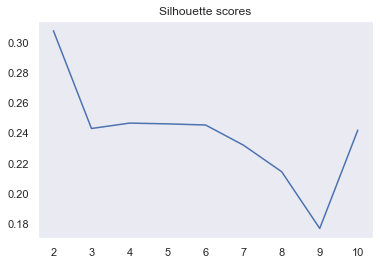

In [178]:
sil_scores = calc_silhouette_scores(X)
plt.plot(range(2,11), sil_scores)
plt.title('Silhouette scores');

In [179]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
coms_kmeans = dict(defaultdict())

for word, label in zip(nn_words, kmeans.labels_):
    if label in coms_kmeans:
        coms_kmeans[label].append(word)
    else:
        coms_kmeans[label] = [word]

In [163]:
from wordcloud import WordCloud

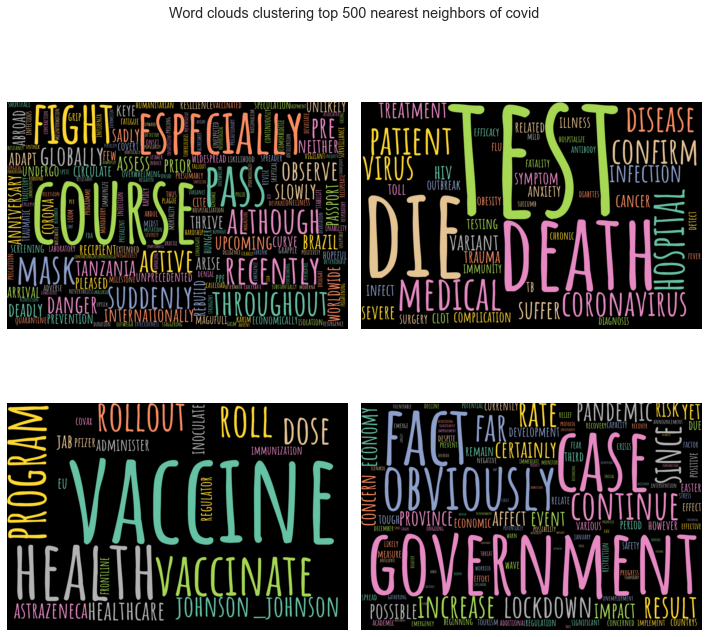

In [181]:
fig, axes = plt.subplots(2,2, figsize=(10,10))
axes = [a for sublist in axes for a in sublist]

for i in range(4):
    wordcloud = WordCloud(width = 3000, height = 2000,
                          background_color='black', colormap='Set2', font_path=font_path,)
    wordcloud.generate_from_frequencies(frequencies={n:SA_COUNTER[n] for n in coms_kmeans[i]} )
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis("off")

plt.suptitle('Word clouds clustering top 500 nearest neighbors of covid')
plt.tight_layout()
plt.show()

## Topic Modeling

In [62]:
from sklearn.feature_extraction.text import CountVectorizer

In [40]:
docs = south_africa.tokens_proc

In [61]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
dtm_tf = tf_vectorizer.fit_transform(docs)
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(docs)

NameError: name 'CountVectorizer' is not defined

In [ ]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)


In [39]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary


In [41]:
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
print('Number of unique words in initital documents:', len(dictionary))

# Filter out words that occur less than 10 documents, or more than 20% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.2)
print('Number of unique words after removing rare and common words:', len(dictionary))

Number of unique words in initital documents: 65890
Number of unique words after removing rare and common words: 21647


In [43]:
corpus = [dictionary.doc2bow(doc) for doc in docs]


In [45]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 21647
Number of documents: 33131


In [44]:
num_topics = 10
chunksize = 500 # size of the doc looked at every pass
passes = 20 # number of passes through documents
iterations = 400
eval_every = 1  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

%time model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)


CPU times: user 13min 11s, sys: 3.62 s, total: 13min 14s
Wall time: 13min 21s


In [58]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

In [60]:
gensimvis.prepare(model, corpus, dictionary)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.003381 -0.049286       1        1  45.105936
2     -0.252512 -0.012970       2        1  22.145549
0      0.157322 -0.163030       3        1  17.138288
1      0.098571  0.225285       4        1  15.610227, topic_info=         Term          Freq         Total Category  logprob  loglift
2105  traffic  12727.000000  12727.000000  Default  30.0000  30.0000
1891    court  14918.000000  14918.000000  Default  29.0000  29.0000
404   vaccine  13768.000000  13768.000000  Default  28.0000  28.0000
126      road  12933.000000  12933.000000  Default  27.0000  27.0000
602    police  11740.000000  11740.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
1178    touch   2686.317080   6235.727402   Topic4  -5.9975   1.0151
2206     sell   2745.185393   7757.235216   Topic4  -5.9759   0.8185
165      walk   2782.658990   9077.379731   Topic4  -5.9623   0.6749
940       low   2724.901216   8063.432044   Topic4  -5.9833   0.7723
1023     bank   2635.773270   8319.623874   Topic4  -6.0165   0.7078

[302 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
5097      1  0.040692   accident
5097      3  0.028848   accident
5097      4  0.930383   accident
3576      2  0.999740     accuse
1108      1  0.124299  afternoon
...     ...       ...        ...
285       3  0.012997  yesterday
285       4  0.288618  yesterday
4695      2  0.998997      zonda
1465      2  0.943696       zuma
1465      3  0.056238       zuma

[576 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 2])

## Train Models
First, train the 50 Word2Vec models per semantic space. Bootstrap documents (sample with replacement) each time.

In [137]:
def generate_bootstrapped_models(country, week_name, num_runs, mode, min_count=5, workers=1):
    """
        Generate models for each country and week num_runs times, for each of the 3 modes:
        (The 3 modes are used by Antoniak & Mimno)
        1. Fixed: Same documents, same order
        2. Shuffled: Same documents, shuffled order
        3. Bootstrap: Sample documents with replacement, total number of len(Fixed) times
        
        :params workers: Must be 1 in order to force randomness to be controlled.
            More workers = faster training, though
        :Returns MODELS: Dict of Dict of lists. First level of dict is modes. List of models
    """
    assert mode in ["fixed", "shuffled", "bootstrap"]
    
    MODELS = []

    for i in range(num_runs):
        # NOTE: Maybe will remove this for more random noise?
        # Random seeds for reproducibility
        random_seed = i*11
        # Random seed for reproducing bootstrapping and shuffling
        random.seed(random_seed)

        weekly_posts = list(TRAIN_POSTS[country][week_name].copy())
        bootstrapped_posts = random.choices(weekly_posts, k=len(weekly_posts))
        
        if mode=="fixed":
            MODELS.append(
                Word2Vec(
                    sentences = weekly_posts, 
                    seed=random_seed,
                    workers=workers,
                    min_count=min_count
                )
            )

        if mode=="shuffled":
            random.shuffle(weekly_posts)
            MODELS.append(
                Word2Vec(
                    sentences = weekly_posts,
                    seed=random_seed,
                    workers=workers,
                    min_count=min_count
                )
            )
            
        if mode=="bootstrap":
            # Bootstrap posts with replacement
            MODELS.append(
                Word2Vec(
                    sentences = bootstrapped_posts,
                    seed=random_seed,
                    workers=workers,
                    min_count=min_count
                )
            )
        
    return MODELS

def get_top_nn_for_model(MODELS, num_runs, vaccine_list, k=200):
    """
        Calculate the top k nearest neighbors for each vaccine word, for each model
        :params MODELS: A dict of lists of models.
        :params k: (int) Number of nearest neighbors to extract
        :params vaccine_list: (str list) Vaccine words of which to get the nearest neighbors
        
        :Returns: (DataFrame) Top k nearest neighbors for each vaccine word in vaccine_list
            Additionally, with the following values:
            * Mean rank of that word in the top-NN list
            * Standard deviation of that word's rank
            * Mean cosine similarity of that word to vaccine
            * Standard deviation of that word's cosine similarity
            * Count of that word (number of times it shows up in the top-NN list)
            * p_count: percentage of times it shows up on the top-NN list
        
    """
    def f(x):
        """Helper function to calculate mean and std for rank and cosine sim"""
        d = {}

        # How many times does this top word appear?
        d['count'] = len(x)
        # Percentage of how many times this top word appears
        d['p_count'] = len(x)/num_runs

        # Mean and std of this top word's rank
        d['rank_mean'] = x['rank'].mean()
        d['rank_std'] = x['rank'].std()

        # Mean and std of this top word's cosine similarity
        d['cos_mean'] = x['cos_sim'].mean()
        d['cos_std'] = x['cos_sim'].std()

        return pd.Series(d, index=['count', 'p_count', 'rank_mean', 'rank_std', 
                                   'cos_mean', 'cos_std'])

    top_nn = []
    for i,m in enumerate(MODELS):
        for vaccine in vaccine_list:

            # If the vaccine is NOT in the vocabulary, do not do it
            if vaccine not in m.wv:
                continue

            # Get the top 100 nearest neighbor for each vaccine, for each model iteration
            top_words = m.wv.most_similar(vaccine, topn=k)

            for word_rank, (word, cos_sim) in enumerate(top_words):
                top_nn.append({
                    "vaccine": vaccine,
                    "top_word": word,
                    "rank": word_rank+1, # Enumerate starts with 0 and we want rank to start with 1
                    "cos_sim": cos_sim,
                    "model_num": i
                })
    top_nn_models = pd.DataFrame(top_nn) 
    
    top_nn_df = top_nn_models.groupby(["vaccine", "top_word"]).apply(f)
    top_nn_df = top_nn_df.astype({"count": 'int'})
    top_nn_df.reset_index(inplace=True)
    
    return top_nn_df

def get_stable_nn_after_bootstrapping(top_nn_df, p=0.95):
    """
        :param top_nn_df: (DataFrame)
        :param p: The percentage of times we want the word to be in bootstrapped
            sample for us to consider it as a stable nearest neighbor
        
        :returns: Dict of vaccines, each item mapping to a list of its
        top NN words (which have appeared in at least threshold percent of models),
        its ranking (ordered by mean cosine similarity), 
        and its mean cosine similarity with the vaccine word
    """

    # These are the top NN after bootstrapping
    TOP_NN_STABLE = defaultdict()

    temp = top_nn_df[top_nn_df["p_count"] > p] \
        .groupby(["vaccine", "top_word"])[["rank_mean", "rank_std", "cos_mean", "cos_std"]]\
        .mean()\
        .sort_values(by=["vaccine", "cos_mean"], ascending=[True, False])\
        .reset_index()

    for vaccine, row in temp.groupby("vaccine"):
    #     print(vaccine)
        if vaccine not in TOP_NN_STABLE:
            TOP_NN_STABLE[vaccine] = list()

        for i, (_, row_row) in enumerate(row.iterrows()):
            TOP_NN_STABLE[vaccine].append({
                "top_word": row_row["top_word"],
                "cos": row_row["cos_mean"],
                "rank": i+1
            })
            
    return TOP_NN_STABLE

In [138]:
# Need to only run this once!
# Takes a while though, bc we are making a lot of models
MODELS = defaultdict()
num_runs = 50

for country in COUNTRIES:
    MODELS[country] = defaultdict()
    for week_name in WEEK_NAMES:
        print(country, week_name)
        
        # Bootstrap models num_runs times 
        MODELS[country][week_name] = generate_bootstrapped_models(
            country, 
            week_name, 
            num_runs=num_runs, 
            mode="bootstrap",
            workers=4
        )

south_africa w0
south_africa w1
south_africa w2
south_africa w3
south_africa w4
south_africa w5
south_africa w6
south_africa w7
nigeria w0
nigeria w1
nigeria w2
nigeria w3
nigeria w4
nigeria w5
nigeria w6
nigeria w7


## Calculate Metrics from Bootstrap Models

### Calculate Top-N Stable Nearest Neighbors

In [6020]:
# Get top NN for each country and week's bootstrapped models
TOP_NN_DFS = defaultdict()
for country in COUNTRIES:
    TOP_NN_DFS[country] = defaultdict()
    for week_name in WEEK_NAMES:
        print(country, week_name)
        top_nn_df = get_top_nn_for_model(
            MODELS[country][week_name], 
            num_runs,
            ["astrazeneca","moderna","pfizer","johnson_johnson","covax","vaccine"],
            k = 300
        )
        TOP_NN_DFS[country][week_name] = top_nn_df
        
# Save to CSV
for country in COUNTRIES:
    for week in WEEK_NAMES:
        TOP_NN_DFS[country][week].to_csv(f"data/analysis/topNN_{country}_{week}.csv", index=False)

In [660]:
# Calculate the STABLE NNs for 50% cutoff
TOP_NN_STABLE_50 = defaultdict()

for country in COUNTRIES:
    TOP_NN_STABLE_50[country] = defaultdict()
    for week_name in WEEK_NAMES:
#         print(country, week_name)
        TOP_NN_STABLE_50[country][week_name] = get_stable_nn_after_bootstrapping(
            TOP_NN_DFS[country][week_name],
            p=0.50)
        
# Save top_nn_stable to json
with open('data/analysis/top_nn_stable_50.json', 'w', encoding='utf-8') as f:
    json.dump(dict(TOP_NN_STABLE_50), f)

In [6027]:
# Calculate the STABLE NNs for 75% cutoff
TOP_NN_STABLE = defaultdict()

for country in COUNTRIES:
    TOP_NN_STABLE[country] = defaultdict()
    for week_name in WEEK_NAMES:
#         print(country, week_name)
        TOP_NN_STABLE[country][week_name] = get_stable_nn_after_bootstrapping(
            TOP_NN_DFS[country][week_name],
            p=0.75)
        
# Save top_nn_stable to json
with open('data/analysis/top_nn_stable.json', 'w', encoding='utf-8') as f:
    json.dump(dict(TOP_NN_STABLE), f)

In [643]:
# Calculate the STABLE NNs for 95% cutoff
TOP_NN_STABLE_95 = defaultdict()

for country in COUNTRIES:
    TOP_NN_STABLE_95[country] = defaultdict()
    for week_name in WEEK_NAMES:
#         print(country, week_name)
        TOP_NN_STABLE_95[country][week_name] = get_stable_nn_after_bootstrapping(
            TOP_NN_DFS[country][week_name],
            p=0.95)
        
# Save top_nn_stable to json
with open('data/analysis/top_nn_stable_95.json', 'w', encoding='utf-8') as f:
    json.dump(dict(TOP_NN_STABLE_95), f)

### Calculate Similarity Measures of Local and Global Events

In [196]:
# Calculate the co-sim for global event in both Nigeria and South AFrica
res = []
for country in COUNTRIES:
    for week in WEEK_NAMES:
        for i, m in enumerate(MODELS[country][week]):
            # Average the embeddings for blood and clot, if they exist in the vocab
            if "clot" not in m.wv: continue
            vecs = [m.wv[word] for word in ["clot"] if word in m.wv]
            vecs = np.mean(vecs, axis=0)
            res.append({
                "country": country,
                "week": week,
                "cos_sim": get_cosine_similarity(m.wv["astrazeneca"], vecs),
                "model_num": i
            })
cos_sim_global_clot = pd.DataFrame(res)
cos_sim_global_clot.to_csv("data/analysis/cos_sim_global_clot.csv", index=False)

## Stability

### Number of Top-N Stable Nearest Neighbors

In [6]:
def calculate_top_nn_stable_metrics(top_nn_stable):
    top_nn_stable_metrics = []

    for country in COUNTRIES:
        for week_name in WEEK_NAMES:
            for word in ["astrazeneca","johnson_johnson"]:
                if word in top_nn_stable[country][week_name]:

                    top_words_stable = [w["top_word"] for w in top_nn_stable[country][week_name][word]]


                    top_nn_stable_metrics.append({
                        "country": country,
                        "week": week_name,
                        "word": word,
                        "num_stable": len(top_nn_stable[country][week_name][word]),
                        "num_total": len(TOP_NN_DFS[country][week_name][TOP_NN_DFS[country][week_name].vaccine==word]),
                    })
    top_nn_stable_metrics_df = pd.DataFrame(top_nn_stable_metrics)
    top_nn_stable_metrics_df["p_nn"] = top_nn_stable_metrics_df["num_stable"] / top_nn_stable_metrics_df["num_total"]
    
    return top_nn_stable_metrics_df

def plot_top_nn_metrics(top_nn_stable_metrics_df, plt):
    fig, axes = plt.subplots(1,2, figsize=(15,5))

    for ax, vaccine in zip(axes, ["astrazeneca", "johnson_johnson"]):
        data = top_nn_stable_metrics_df[top_nn_stable_metrics_df.word==vaccine]
        splot = sns.barplot(data=data, x="week", y="num_stable", hue="country", 
                            ax=ax, palette="Dark2")

        # Annotate the bars in plot
        # https://stackoverflow.com/questions/43214978/seaborn-barplot-displaying-values
        for p in splot.patches:
            if not np.isnan(p.get_height()):
                splot.annotate(int(p.get_height()), 
                               (p.get_x() + p.get_width() / 2., p.get_height()), 
                               ha = 'center', va = 'center', 
                               xytext = (0, 9), 
                               textcoords = 'offset points',
                               size=14
                                )
        # set y lim to be equal to both
        ax.set_ylim((0,max(top_nn_stable_metrics_df.num_stable)+1))
        # remove y label and ticks
        ax.set_ylabel('')
        ax.set_yticklabels('')

        # x axis
        ax.set_xlabel('Week', size=18)
        ax.set_xticklabels(WEEK_NAMES, size=14)

        ax.set_title(prettify_vaccine[vaccine], size=18)
        ax.get_legend().remove()

    handles, labels = plt.gca().get_legend_handles_labels()
    labels = [prettify_country[c] for c in labels]
    plt.figlegend(handles, labels, loc="lower center", ncol=2, frameon=False, fontsize=18,
                 bbox_to_anchor=(0.5, 0.98))


    sns.despine(top=True, right=True, left=True, bottom=True)

In [5]:
# Load in the JSON files of stable nearest neighbors

# Get the top stable NNs
with open('data/analysis/top_nn_stable.json', 'r', encoding='utf-8') as f:
    TOP_NN_STABLE = json.load(f)

# Get the DataFrames for top NN for each semantic space
TOP_NN_DFS = defaultdict()
for country in COUNTRIES:
    TOP_NN_DFS[country] = defaultdict()
    for week in WEEK_NAMES:
        TOP_NN_DFS[country][week] = pd.read_csv(f"data/analysis/topNN_{country}_{week}.csv")


In [8]:
# for the 50% cutoff
# top_nn_stable_metrics_df_50 = calculate_top_nn_stable_metrics(TOP_NN_STABLE_50)

# for 75% cutoff
top_nn_stable_metrics_df_75 = calculate_top_nn_stable_metrics(TOP_NN_STABLE)

# for 95% cutoff
# top_nn_stable_metrics_df_95 = calculate_top_nn_stable_metrics(TOP_NN_STABLE_95)

<ipython-input-20-a7624fd6460d>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])


[Text(0, 0.0, '0.00%'),
 Text(0, 0.01, '1.00%'),
 Text(0, 0.02, '2.00%'),
 Text(0, 0.03, '3.00%'),
 Text(0, 0.04, '4.00%'),
 Text(0, 0.05, '5.00%'),
 Text(0, 0.06, '6.00%'),
 Text(0, 0.07, '7.00%'),
 Text(0, 0.08, '8.00%'),
 Text(0, 0.09, '9.00%')]

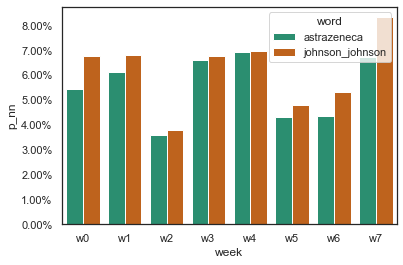

In [20]:
### FOR BLOG

data = top_nn_stable_metrics_df_75[top_nn_stable_metrics_df_75.country=="south_africa"]
ax = sns.barplot(data=data, x='week', y='p_nn', ci=None, hue='word', palette="Dark2")
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

In [13]:
data

,country,week,word,num_stable,num_total,p_nn
0,south_africa,w0,astrazeneca,113,2070,0.054589
1,south_africa,w0,johnson_johnson,123,1822,0.067508
2,south_africa,w1,astrazeneca,108,1760,0.061364
3,south_africa,w1,johnson_johnson,117,1714,0.068261
4,south_africa,w2,astrazeneca,79,2197,0.035958
5,south_africa,w2,johnson_johnson,86,2256,0.038121
6,south_africa,w3,astrazeneca,119,1797,0.066221
7,south_africa,w3,johnson_johnson,122,1799,0.067815
8,south_africa,w4,astrazeneca,118,1705,0.069208
9,south_africa,w4,johnson_johnson,115,1652,0.069613


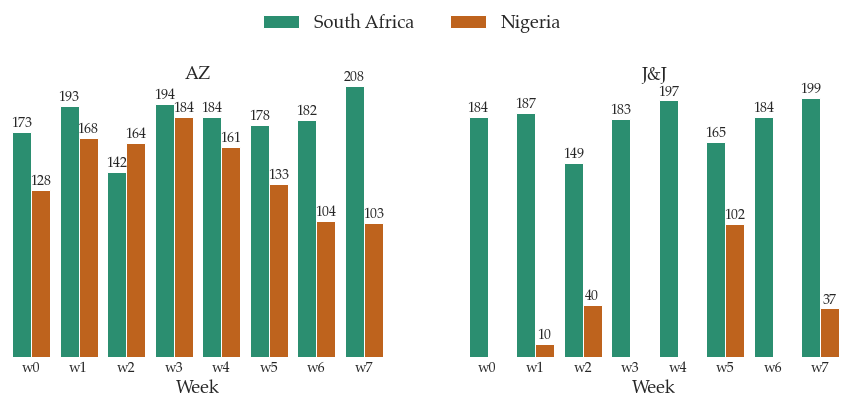

In [665]:
plot_top_nn_metrics(top_nn_stable_metrics_df_50, plt)
plt.savefig('img/APPENDIX_top_stable_nn_barplot_50.png', bbox_inches='tight') 

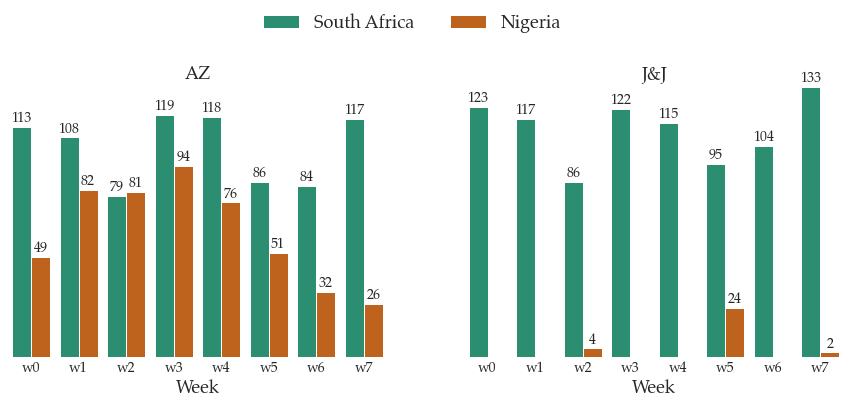

In [656]:
plot_top_nn_metrics(top_nn_stable_metrics_df_75, plt)
plt.savefig('img/top_stable_nn_barplot.png', bbox_inches='tight') 

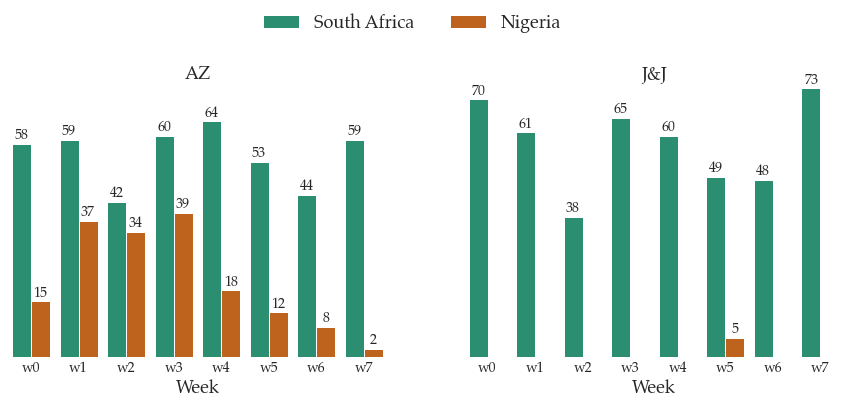

In [658]:
plot_top_nn_metrics(top_nn_stable_metrics_df_95, plt)
plt.savefig('img/APPENDIX_top_stable_nn_barplot_95.png', bbox_inches='tight') 

### Variance Within Models (Histograms)

In [463]:
def plot_histogram_nn_bootstrap(ni_dist, sa_dist, yscale_log=False):
    """
        Plots a histogram given the Nigeria and South Africa distributions
        for any given values, and styles them
    """
    sns.histplot(data=ni_dist, color='orange', kde=True, 
                 line_kws = {"linewidth": 3}, bins=50)
    sns.histplot(data=sa_dist, color='teal', kde=True, 
                 line_kws = {"linewidth": 3}, bins=50)    

    sns.despine(top=True, right=True, left=True, bottom=True)

    legend = plt.legend(
        handles=[
            mpatches.Patch(color='orange', label='Nigeria'),
            mpatches.Patch(color='teal', label='South Africa'),
        ], 
        frameon=False, 
        loc='upper right',
        fontsize=16, 
        bbox_to_anchor=((0.95, 0.8))
    )

    for lh in legend.legendHandles: 
        lh.set_alpha(0.6)


In [21]:
# What is the percentage of models (over all weeks, aggregated) that a word appears in?
ni_p_count = []
sa_p_count = []
# What is the standard deviation of cos similarity for nearest neighbors
ni_cos_std = []
sa_cos_std = []
# What is the standard deviation of rank of nearest neighbors
ni_rank_std = []
sa_rank_std = []
for week in WEEK_NAMES:
    ni_p_count.extend(TOP_NN_DFS["nigeria"][week][TOP_NN_DFS["nigeria"][week].vaccine=="astrazeneca"]["p_count"])
    sa_p_count.extend(TOP_NN_DFS["south_africa"][week][TOP_NN_DFS["south_africa"][week].vaccine=="astrazeneca"]["p_count"])
    ni_cos_std.extend(TOP_NN_DFS["nigeria"][week][TOP_NN_DFS["nigeria"][week].vaccine=="astrazeneca"]["cos_std"])
    sa_cos_std.extend(TOP_NN_DFS["south_africa"][week][TOP_NN_DFS["south_africa"][week].vaccine=="astrazeneca"]["cos_std"])
    ni_rank_std.extend(TOP_NN_DFS["nigeria"][week][TOP_NN_DFS["nigeria"][week].vaccine=="astrazeneca"]["rank_std"])
    sa_rank_std.extend(TOP_NN_DFS["south_africa"][week][TOP_NN_DFS["south_africa"][week].vaccine=="astrazeneca"]["rank_std"])


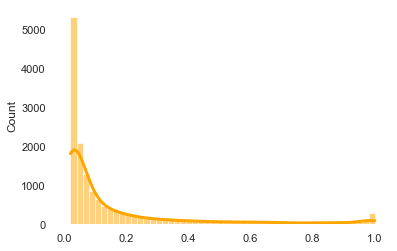

In [24]:
### FOR BLOG
sns.histplot(data=sa_p_count, color='orange', kde=True, 
                 line_kws = {"linewidth": 3}, bins=50)

sns.despine(top=True, right=True, left=True, bottom=True)


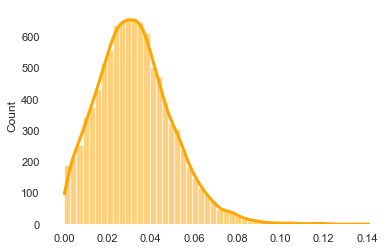

In [31]:
### FOR BLOG
sns.histplot(data=sa_cos_std, color='orange', kde=True, 
                 line_kws = {"linewidth": 3}, bins=50)

sns.despine(top=True, right=True, left=True, bottom=True)


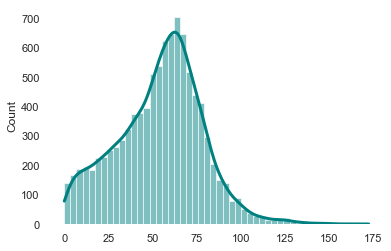

In [30]:
### FOR BLOG

sns.histplot(data=sa_rank_std, color='teal', kde=True, 
                 line_kws = {"linewidth": 3}, bins=50)
sns.despine(top=True, right=True, left=True, bottom=True)


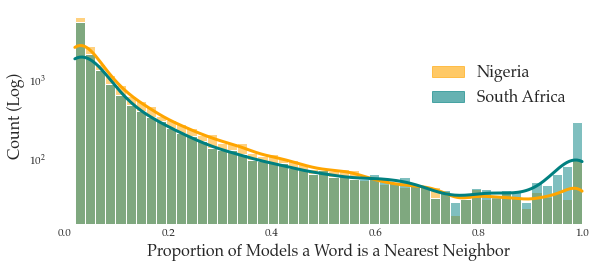

In [524]:
plt.figure(figsize=(10, 4))
plot_histogram_nn_bootstrap(ni_p_count, sa_p_count)
plt.yscale('log')
plt.ylabel('Count (Log)', size=16)
plt.xlabel('Proportion of Models a Word is a Nearest Neighbor', size=16)
plt.savefig('img/hist_nn_percent_models.png', bbox_inches='tight') 


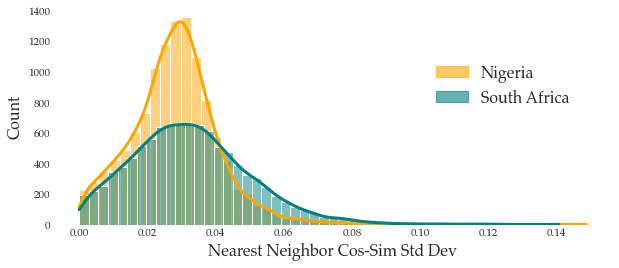

In [525]:
plt.figure(figsize=(10, 4))
plot_histogram_nn_bootstrap(ni_cos_std, sa_cos_std)
plt.ylabel('Count', size=16)
plt.xlabel('Nearest Neighbor Cos-Sim Std Dev', size=16)
plt.savefig('img/hist_nn_cos_sim_std.png', bbox_inches='tight') 


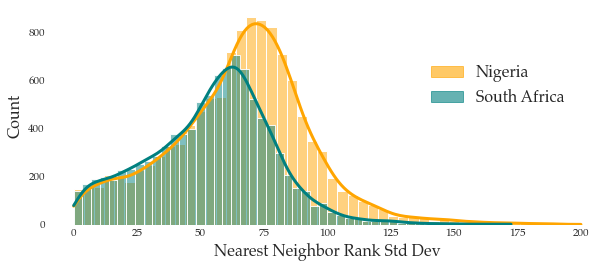

In [526]:
plt.figure(figsize=(10, 4))
plot_histogram_nn_bootstrap(ni_rank_std, sa_rank_std)
plt.ylabel('Count', size=16)
plt.xlabel('Nearest Neighbor Rank Std Dev', size=16)
plt.savefig('img/hist_nn_rank_std.png', bbox_inches='tight') 


### Qualitative Analysis of the stable top NN per week and country

In [5293]:
def format_top_nn_for_vaccine(vaccine, n=5):
    """
        Gets the top n (stable) NN for the vaccine, for each country and week,
        as well as the cosine similarity of that word to the vaccine
        Formats in this beautiful multiindex DataFrame that took me ages to make
    """
    
    top_nn_after_bootstrap = []
    for country in COUNTRIES:
        for i in range(n):
            acc = []
            for week in WEEK_NAMES:
                if vaccine not in TOP_NN_STABLE[country][week].keys():
                    acc.extend(np.array([None, None]))
                    
                elif len(TOP_NN_STABLE[country][week][vaccine]) <= i:
                    acc.extend(np.array([None, None]))
                
                else:
                    acc.extend(np.array([
                        TOP_NN_STABLE[country][week][vaccine][i]['top_word'],
                        TOP_NN_STABLE[country][week][vaccine][i]['cos']
                    ]))

            top_nn_after_bootstrap.append(acc)
            
    miindex = pd.MultiIndex.from_product(
#         [WEEK_NAMES, range(1,n+1)]
        [['South Africa', 'Nigeria'], range(1,n+1)]
    )

    micolumns = pd.MultiIndex.from_tuples(
#         [("South Africa", "word"), ("South Africa", "cos"),
#         ("Nigeria", "word"), ("Nigeria", "cos")
        [("w0", "word"), ("w0", "cos"), 
        ("w1", "word"), ("w1", "cos"),
        ("w2", "word"), ("w2", "cos"),
        ("w3", "word"), ("w3", "cos"),
        ("w4", "word"), ("w4", "cos"),
        ("w5", "word"), ("w5", "cos"),
        ("w6", "word"), ("w6", "cos"),
        ("w7", "word"), ("w7", "cos")
        ]
    )
    dfmi = (
        pd.DataFrame(
            np.array(top_nn_after_bootstrap).reshape((len(miindex), len(micolumns))),
            index=miindex,
            columns=micolumns,
        )
    )

    return dfmi

In [6069]:
az_top_nn = format_top_nn_for_vaccine("astrazeneca",n=5)
jj_top_nn = format_top_nn_for_vaccine("johnson_johnson",n=5)
# jj_top_nn.to_csv("data/analysis/jj_top_nn.csv")
# az_top_nn.to_csv("data/analysis/az_top_nn.csv")

In [6071]:
az_top_nn


w0                                   w1  \
                           word                 cos             word   
South Africa 1           pfizer   0.860763019323349          vaccine   
             2          procure  0.8310522568225861  johnson_johnson   
             3  johnson_johnson  0.8149835920333862      nationalism   
             4       administer  0.8148053205013275             dose   
             5         efficacy  0.8091866493225097          rollout   
Nigeria      1            covax  0.9322488844394684           oxford   
             2           oxford  0.9312453768691238             dose   
             3             dose  0.9251949501037597          rollout   
             4          rollout  0.8710612201690674            covax   
             5          vaccine  0.8706338441371918           pfizer   

                                                 w2                      \
                               cos             word                 cos   
South Africa 1  0.8559680819511414          vaccine  0.8501730763912201   
             2  0.8322357642650604             dose  0.8453765296936036   
             3  0.8158739161491394  johnson_johnson  0.8388254725933075   
             4  0.8145412480831147          rollout  0.8269297564029694   
             5  0.7846849727630615           oxford  0.8235406947135925   
Nigeria      1  0.9754235327243805           oxford   0.944546080827713   
             2  0.9449009728431702       administer  0.9244419181346893   
             3  0.9306303632259368            batch  0.9163009905815125   
             4  0.9292405939102173          rollout  0.9087399029731751   
             5  0.9153765916824341             dose  0.8942517983913422   

                             w3                                   w4  \
                           word                 cos             word   
South Africa 1          vaccine  0.8868699645996094  johnson_johnson   
             2          rollout  0.8701548993587493          vaccine   
             3  johnson_johnson  0.8672726166248321             dose   
             4               eu   0.860787535905838          rollout   
             5           oxford  0.8313932406902313          sputnik   
Nigeria      1           oxford  0.9615365040302276           oxford   
             2          vaccine  0.9593782150745391     racketeering   
             3             clot  0.9567754912376404          rollout   
             4            blood  0.9393259882926941           nafdac   
             5          suspend  0.9379629421234131           export   

                                                 w5                      \
                               cos             word                 cos   
South Africa 1   0.880877091884613  johnson_johnson  0.9069876837730407   
             2  0.8569385004043579          vaccine  0.8758652651309967   
             3  0.8319186735153198           pfizer  0.8704811871051789   
             4  0.8040055215358735          sputnik  0.8702340936660766   
             5  0.7968174274577651           oxford  0.8697676718235016   
Nigeria      1  0.9767334818840027       administer    0.96367138504982   
             2  0.9461669826507568  johnson_johnson  0.9557962894439698   
             3  0.9372478236957472            adopt  0.9492614102363587   
             4   0.934232485294342           oxford  0.9442357407963794   
             5  0.9339753016829491        effective  0.9350017833709717   

                             w6                                   w7  \
                           word                 cos             word   
South Africa 1              jab  0.8770039701461791  johnson_johnson   
             2          vaccine   0.875083509683609          vaccine   
             3           oxford    0.87028036236763              jab   
             4  johnson_johnson   0.861225436925888       administer   
             5           pfizer  0.8573321115970611          roll

In [6072]:
jj_top_nn

w0                               w1  \
                      word                 cos         word   
South Africa 1       batch   0.878915638923645         dose   
             2        dose  0.8473343980312348          jab   
             3  administer  0.8284178793430328  astrazeneca   
             4         jab  0.8278396725654602      rollout   
             5        vial  0.8222063136100769   administer   
Nigeria      1        None                None         None   
             2        None                None         None   
             3        None                None         None   
             4        None                None         None   
             5        None                None         None   

                                             w2                      \
                               cos         word                 cos   
South Africa 1  0.8667070639133453      vaccine  0.8667334616184235   
             2  0.8541246950626373  astrazeneca  0.8388254809379577   
             3   0.832235758304596     efficacy  0.8387082159519196   
             4  0.8259573078155518      rollout  0.8286580491065979   
             5  0.8093536996841431         dose  0.7975184953212738   
Nigeria      1                None        covax  0.8750175300397371   
             2                None          ptf  0.8633004787721132   
             3                None      denmark  0.8550761577330137   
             4                None        shehu  0.8397764783156546   
             5                None         None                None   

                         w3                               w4  \
                       word                 cos         word   
South Africa 1  astrazeneca  0.8672726261615753      rollout   
             2      vaccine   0.848970593214035  astrazeneca   
             3         dose  0.8459358751773834      vaccine   
             4      rollout  0.8417664992809296          jab   
             5          jab  0.8412461495399475   administer   
Nigeria      1         None                None         None   
             2         None                None         None   
             3         None                None         None   
             4         None                None         None   
             5         None                None         None   

                                             w5                      \
                               cos         word                 cos   
South Africa 1  0.8869989097118378  astrazeneca  0.9069876849651337   
             2  0.8808770895004272         dose  0.8795287907123566   
             3  0.8652182328701019      vaccine  0.8747303628921509   
             4  0.8327905750274658      sputnik  0.8617847800254822   
             5  0.8233567225933075       pfizer  0.8546781086921692   
Nigeria      1                None  astrazeneca  0.9557962870597839   
             2                None   administer  0.9433901906013489   
             3                None        ditch   0.922614132746672   
             4                None      rollout  0.9177543158116548   
             5                None         dose  0.9150026571750641   

                         w6                               w7  \
                       word                 cos         word   
South Africa 1         dose  0.9096095812320709      rollout   
             2  astrazeneca  0.8612254238128663          jab   
             3          jab   0.859421409368515  astrazeneca   
             4      vaccine   0.831648964881897      vaccine   
             5       pfizer  0.8271219444274902         halt   
Nigeria      1         None                None      alleged   
             2         None                None  appointment   
             3         None                None         None   
             4         None                None         None   
             5         None                None         None   

                       

# RQ1: Measuring Change over Time
Using Jaccard similarity of (stable) nearest neighbors

## Temporal Change
How have the nearest neighbors changed as compared to the previous week?

In [575]:
# The three examples I will look at
country_vaccine_pair = 
[
    ("nigeria", "astrazeneca"),
    ("south_africa", "astrazeneca"), 
    ("south_africa", "johnson_johnson")
]

In [625]:
# Incremental Jaccard scores -- as compared to the previous week
scores_incremental = []
for k in [5, 10, 25, 50, 75, 100]:
    for country, vaccine in country_vaccine_pair:
        for (w1, w2) in WEEK_NAMES_SPLITS:
            if vaccine not in TOP_NN_STABLE[country][w1] or vaccine not in TOP_NN_STABLE[country][w2]:
                score = 0
            else:
                score = jaccard_score(
                    [w["top_word"] for w in TOP_NN_STABLE[country][w1][vaccine]],
                    [w["top_word"] for w in TOP_NN_STABLE[country][w2][vaccine]],
                    k=k
                )
            scores_incremental.append({
                "country": country,
                "vaccine": vaccine,
                "country-vaccine": f"{prettify_vaccine[vaccine]} ({prettify_country[country]})",
                "week": f"{w2}",
                "score": score,
                "k":k
            })
scores_incremental_df = pd.DataFrame(scores_incremental)

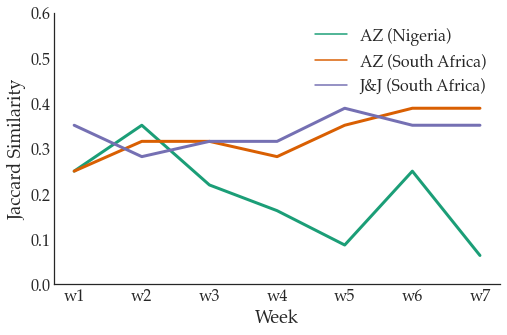

In [584]:
plt.figure(figsize=(8,5))

ax = sns.lineplot(data=scores_incremental_df[scores_incremental_df.k==25],
             x="week_split", y="score", hue="country-vaccine",
            palette="Dark2", linewidth=3)

plt.legend(title=None, loc='upper right', frameon=False, fontsize=16)
plt.ylabel('Jaccard Similarity', size=18)
plt.yticks(size=16)
plt.ylim((0,0.6))
plt.xlabel('Week', size=18)
plt.xticks(size=16)

sns.despine(top=True, right=True)

# plt.title('Intersection Score, compared to previous week, for AstraZeneca nearest neighbors')
plt.savefig('img/jaccard_weekly.png', bbox_inches='tight') 

plt.show()


### Varying $N$, for Nigeira + AZ (APPENDIX)

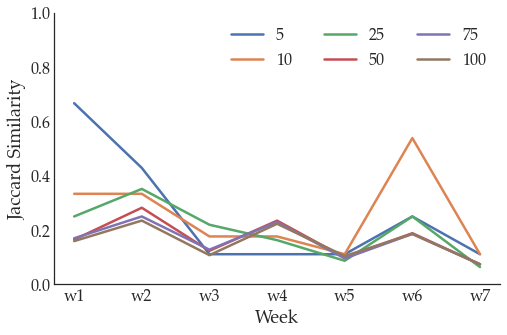

In [641]:
plt.figure(figsize=(8,5))
data_nigeria_az=scores_incremental_df[scores_incremental_df.country=="nigeria"]

for k in [5, 10, 25, 50, 75, 100]:
    data=data_nigeria_az[data_nigeria_az.k==k]
    plt.plot(data.week, data.score, label=k, linewidth=2.5)
#     plt.text(7, data.tail(1)['score'],'hi') 

# sns.lineplot(data=scores_within_country_df[scores_within_country_df.k==10], 
#              x="week", y="score", linewidth=3)

plt.ylabel('Jaccard Similarity', size=18)
plt.yticks(size=16)
plt.ylim((0,1))
plt.xlabel('Week', size=18)
plt.xticks(size=16)

plt.legend(fontsize=16, ncol=3)

sns.despine(top=True, right=True)
plt.savefig('img/APPENDIX_jaccard_Ni_AZ.png', bbox_inches='tight') 

plt.show()


### Varying $N$, for South Africa + AZ (APPENDIX)


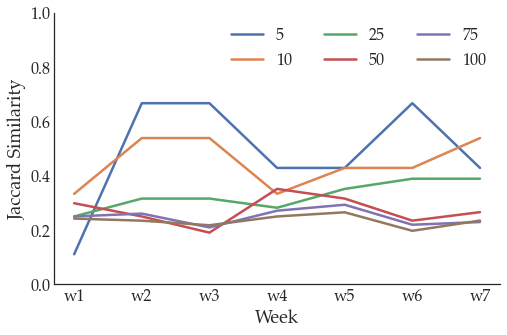

In [642]:
plt.figure(figsize=(8,5))
data_sa_az=scores_incremental_df[(scores_incremental_df.country=="south_africa") & (scores_incremental_df.vaccine=="astrazeneca")]

for k in [5, 10, 25, 50, 75, 100]:
    data=data_sa_az[data_sa_az.k==k]
    plt.plot(data.week, data.score, label=k, linewidth=2.5)
#     plt.text(7, data.tail(1)['score'],'hi') 

# sns.lineplot(data=scores_within_country_df[scores_within_country_df.k==10], 
#              x="week", y="score", linewidth=3)

plt.ylabel('Jaccard Similarity', size=18)
plt.yticks(size=16)
plt.ylim((0,1))
plt.xlabel('Week', size=18)
plt.xticks(size=16)

plt.legend(fontsize=16, ncol=3)

sns.despine(top=True, right=True)
plt.savefig('img/APPENDIX_jaccard_SA_AZ.png', bbox_inches='tight') 

plt.show()


## Geographic Change
How similar are the nearest neighbors between the two countries, for each week?

In [615]:
scores_within_country = []
for k in [5, 10, 25, 50, 75, 100]:

    for week in WEEK_NAMES:
        for vaccine in ["astrazeneca"]:
            if vaccine not in TOP_NN_STABLE["south_africa"][week] or vaccine not in TOP_NN_STABLE["nigeria"][week]:
                score = 0
            else:
                score = jaccard_score(
                    [w["top_word"] for w in TOP_NN_STABLE["south_africa"][week][vaccine]],
                    [w["top_word"] for w in TOP_NN_STABLE["nigeria"][week][vaccine]],
                    k=k
                )
            scores_within_country.append({
                "week": f"{week}",
                "vaccine": vaccine,
                "score": score,
                "k":k
            })
scores_within_country_df = pd.DataFrame(scores_within_country)

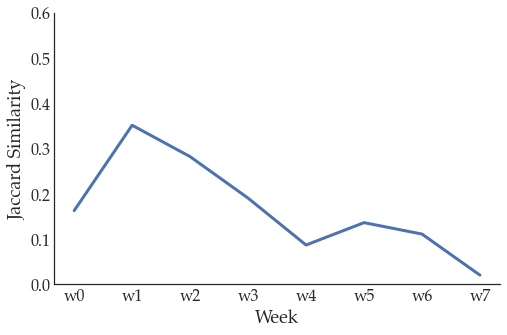

In [587]:
plt.figure(figsize=(8,5))
sns.lineplot(data=scores_within_country_df[scores_within_country_df.k==25], 
             x="week", y="score", linewidth=3)

plt.ylabel('Jaccard Similarity', size=18)
plt.yticks(size=16)
plt.ylim((0,0.6))
plt.xlabel('Week', size=18)
plt.xticks(size=16)

sns.despine(top=True, right=True)
plt.savefig('img/jaccard_between_country.png', bbox_inches='tight') 

plt.show()


### Varying $N$ (APPENDIX)

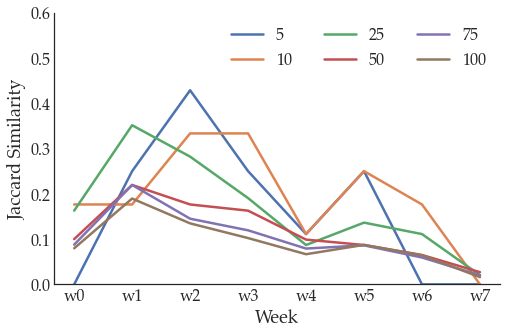

In [639]:
plt.figure(figsize=(8,5))
for k in [5, 10, 25, 50, 75, 100]:
    data=scores_within_country_df[scores_within_country_df.k==k]
    plt.plot(data.week, data.score, label=k, linewidth=2.5)
#     plt.text(7, data.tail(1)['score'],'hi') 

# sns.lineplot(data=scores_within_country_df[scores_within_country_df.k==10], 
#              x="week", y="score", linewidth=3)

plt.ylabel('Jaccard Similarity', size=18)
plt.yticks(size=16)
plt.ylim((0,0.6))
plt.xlabel('Week', size=18)
plt.xticks(size=16)

plt.legend(fontsize=16, ncol=3)

sns.despine(top=True, right=True)
plt.savefig('img/APPENDIX_jaccard_between_country.png', bbox_inches='tight') 

plt.show()


## What are bursty words? (APPENDIX)
Words that appear a few times but have really high similarity measures (cosine)

In [24]:
def calculate_bursty_words(country, vaccine, cos_mean_threshold=0.95):
    """Calculatees top bursty words for given country and vaccine
       based on the following metrics:
       
           * proportion count < .75 (so these were not caught by stable NN cutoff)
           * count > 2 (mentioned more than once)
           * cos_mean > 0.95 (so, super similar)
       
   """
    bursty_words = []

    for week in WEEK_NAMES:
        tnndf = TOP_NN_DFS[country][week]
        bursty = tnndf[(tnndf.vaccine==vaccine) \
                      & (tnndf.p_count < .75)\
                      & (tnndf["count"] > 2) \
                      & (tnndf.cos_mean > cos_mean_threshold)
                     ].sort_values(by="cos_mean", ascending=False)
        bursty["week"] = week
        bursty_words.extend(bursty.values)  
        
    return pd.DataFrame(bursty_words, columns=bursty.columns )

In [25]:
nigeria_az_bursty = calculate_bursty_words("nigeria", "astrazeneca")
nigeria_az_bursty

,vaccine,top_word,count,p_count,rank_mean,rank_std,cos_mean,cos_std,week
0,astrazeneca,transgenic,17,0.34,2.294118,1.829095,0.964593,0.019360,w6
1,astrazeneca,intermediary,3,0.06,90.000000,87.126345,0.953948,0.013817,w7
2,astrazeneca,senatorial,3,0.06,75.666667,46.651188,0.952638,0.014524,w7
3,astrazeneca,sharply,3,0.06,115.333333,31.722757,0.952483,0.008185,w7
4,astrazeneca,rollout,4,0.08,34.250000,42.991278,0.950180,0.010171,w7


In [26]:
nigeria_az_bursty.to_clipboard()

In [27]:
sa_az_bursty = calculate_bursty_words("south_africa", "astrazeneca", cos_mean_threshold=0.8)
sa_az_bursty

,vaccine,top_word,count,p_count,rank_mean,rank_std,cos_mean,cos_std,week
0,astrazeneca,triale,8,0.16,11.000000,9.071147,0.812314,0.039341,w0
1,astrazeneca,sinopharm,19,0.38,8.368421,14.648513,0.815121,0.057152,w4
2,astrazeneca,serum,13,0.26,9.307692,8.400244,0.848918,0.043296,w5
3,astrazeneca,drugmaker,23,0.46,13.521739,8.537988,0.815224,0.044678,w6
4,astrazeneca,biontech,32,0.64,17.968750,27.110865,0.812412,0.056744,w6


In [28]:
sa_az_bursty.to_clipboard()

In [29]:
sa_jj_bursty = calculate_bursty_words("south_africa", "johnson_johnson", cos_mean_threshold=0.8)
sa_jj_bursty

,vaccine,top_word,count,p_count,rank_mean,rank_std,cos_mean,cos_std,week
0,johnson_johnson,sinopharm,19,0.38,12.473684,19.012769,0.830420,0.058883,w4
1,johnson_johnson,mazzuca,19,0.38,9.473684,3.963282,0.825079,0.024066,w4
2,johnson_johnson,serum,13,0.26,10.769231,7.518354,0.808717,0.042900,w5


In [30]:
sa_jj_bursty.to_clipboard()

# RQ2: Real-world (local and global) Events
Using cosine similarity of vaccine word to event keywords for 3 select events

In [98]:
cos_sim_global_clot = pd.read_csv("cos_sim_global_clot.csv")


In [99]:
def get_overlapping(x, y):
    """Returns the items in y that appear within the range of x"""
    return [yy for yy in y if ((yy >= min(x)) and (yy <= max(x)))]

def calc_weekly_cos_mean_overlap(events, event_dfs):
    """
        For given event, determines the proportion of overlap of cosine sim
        from one week as compared to the previous week
        (based on the knowledge that there are 50 model runs)
    
    """
    cos_overlap_within_countries = []
    
    for event, event_df in zip(events, event_dfs):
        for country in COUNTRIES:
            data = event_df[event_df.country==country]

            for w1, w2 in WEEK_NAMES_SPLITS:
                x = data[(data.week==w1)].cos_sim
                y = data[(data.week==w2)].cos_sim
                
                if len(x)==0 or len(y)==0:
                    len_overlap = None
                else:
                    overlap = get_overlapping(x,y)
                    len_overlap = len(overlap) / 50

                cos_overlap_within_countries.append({
                    "week": w2,
                    "overlap": len_overlap,
                    "country": country,
                    'event': event
                })
    
    overlap_df = pd.DataFrame(cos_overlap_within_countries)
    overlap_df = pd.pivot_table(pd.DataFrame(overlap_df), values='overlap', 
                                index=['event', 'country'], columns=['week'])
    
    return overlap_df

def calc_between_country_cos_mean_overlap(events, event_dfs):
    """
        For given event, determines the proportion of overlap of cosine sim
        BETWEEN countries
        (based on the knowledge that there are 50 model runs)
    """
    
    # Overlap BETWEEN the countries
    cos_overlap_between_countries = []
    
    for event, event_df in zip(events, event_dfs):
        data = event_df.copy()

        for week in WEEK_NAMES:
            x = data[(data.country=="south_africa") & (data.week==week)].cos_sim
            y = data[(data.country=="nigeria") & (data.week==week)].cos_sim

            if len(x)==0 or len(y)==0:
                len_overlap = None
            else:
                overlap = get_overlapping(x,y)
                len_overlap = len(overlap) / 50

            cos_overlap_between_countries.append({
                "week": week,
                "overlap": len_overlap,
                'event': event
            })

    overlap_df = pd.DataFrame(cos_overlap_between_countries)
    overlap_df = pd.pivot_table(pd.DataFrame(overlap_df), values='overlap', 
                                index=['event'], columns=['week'])
    return overlap_df    

In [100]:
# Temporal overlap
calc_weekly_cos_mean_overlap(["AZ-clot"], [cos_sim_global_clot])

week                    w1    w2    w3   w4    w5    w6    w7
event   country                                              
AZ-clot nigeria       0.92  0.00  0.00  0.0  0.94  0.72  0.84
        south_africa  1.00  0.14  0.26  0.0  0.00  0.72  0.96

In [101]:
# Country overlap
calc_between_country_cos_mean_overlap(["AZ-clot"], [cos_sim_global_clot])

week,w0,w1,w2,w3,w4,w5,w6,w7
event,,,,,,,,
AZ-clot,0.88,0.74,0.0,0.0,0.0,0.54,0.26,0.1


## Global Event: AZ and blood clot

In [102]:
# average cosine similarity of AZ to blood/clot for each country.
cos_sim_global_clot.groupby(["country", "week"])\
    .mean("cos_sim")\
    .reset_index()\
    .drop(columns="model_num")\
    .set_index("country")\
    .pivot(columns="week")

cos_sim                                                    \
week                w0        w1        w2        w3        w4        w5   
country                                                                    
nigeria       0.101241  0.163876  0.758091  0.953934  0.729265  0.639293   
south_africa  0.206487  0.226268  0.371243  0.492543  0.191649  0.552489   

                                  
week                w6        w7  
country                           
nigeria       0.742693  0.823618  
south_africa  0.622361  0.617123

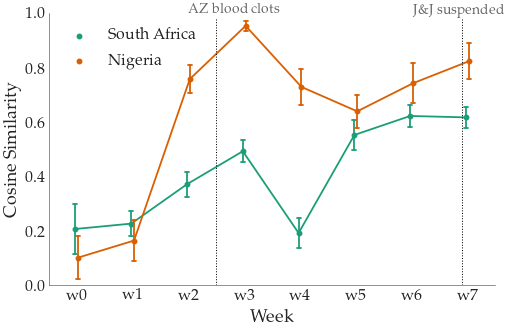

In [116]:
# I average the embedding for blood and clot and find the confidence interval of cosine similarities
plt.figure(figsize=(8, 5))
ax = sns.pointplot(x="week", y="cos_sim", hue='country', data=cos_sim_global_clot, 
              ci="sd", dodge=True, palette='Dark2', capsize=.07)

linestyles=["-", "--"]
sns.despine(top=True, right=True)

plt.xlabel('Week', size=18)
plt.xticks(fontsize=16)
plt.ylabel('Cosine Similarity', size=18)
plt.yticks(fontsize=16)

plt.ylim((0,1))

# Remove all of the extra tick marks
ax.minorticks_off()
ax.tick_params(top=False, right=False)
    
# Add the event lines
# AZ Blood clot event
ax.axvline(x=2.5, ymax=0.98, **kwargs_axvline)
ax.text(x=2, y=1, s='AZ blood clots', **kwargs_text)

# J&J Suspension event
ax.axvline(x=6.9, ymax=0.98, **kwargs_axvline)
ax.text(x=6, y=1, s='J\&J suspended', **kwargs_text)


handles, labels = ax.get_legend_handles_labels()
labels = [prettify_country[c] for c in labels]
plt.legend(handles, labels, loc='upper left', ncol=1, frameon=False, fontsize=16)

# plt.show()
plt.savefig('img/cos_sim_az_clot.pdf', bbox_inches='tight') 


In [210]:
cos_sim_global_clot.week.value_counts()

w3    100
w4     99
w7     98
w2     97
w6     83
w5     52
w0     11
Name: week, dtype: int64

In [203]:
def percentage_change(current, previous):
    if previous != 0 :
        return float(current - previous) / abs(previous) * 100
    else:
        return "undefined"

In [244]:
starting_val_w2 = cos_sim_global_clot[cos_sim_global_clot.week == 'w2']

w3_onwards = cos_sim_global_clot[cos_sim_global_clot.week > 'w1']

In [245]:
w2_cos_sim_mean = starting_val_w2.groupby('country')['cos_sim'].mean()
w2_cos_sim_mean

country
nigeria         0.839167
south_africa    0.439809
Name: cos_sim, dtype: float64

In [246]:
w2_cos_sim_mean.loc["south_africa"]

0.4398091434639819

In [247]:
percentage_change(0.66, 0.43)

53.48837209302326

In [249]:
# Percent change compared to the w2 average
w3_onwards["p_change"] = w3_onwards.apply(lambda x: percentage_change(
    x.cos_sim, 
    w2_cos_sim_mean.loc[x.country]), axis=1)
                                                           
                                                           

In [250]:
w3_onwards

,country,week,cos_sim,model_num,p_change
11,south_africa,w2,0.305278,0,-30.588487
12,south_africa,w2,0.255459,1,-41.915980
13,south_africa,w2,0.475581,2,8.133385
14,south_africa,w2,0.513706,3,16.801940
15,south_africa,w2,0.422241,5,-3.994445
...,...,...,...,...,...
535,nigeria,w7,0.902332,45,7.527178
536,nigeria,w7,0.949756,46,13.178479
537,nigeria,w7,0.892178,47,6.317146
538,nigeria,w7,0.886795,48,5.675610


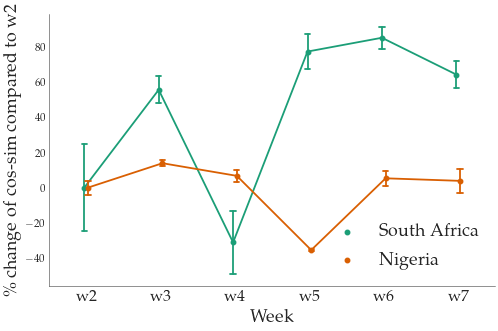

In [251]:
# I average the embedding for blood and clot and find the confidence interval of cosine similarities
plt.figure(figsize=(8, 5))
ax = sns.pointplot(x="week", y="p_change", hue='country', data=w3_onwards, 
              ci="sd", dodge=True, palette="Dark2", capsize=.07)

linestyles=["-", "--"]
sns.despine(top=True, right=True)

plt.xlabel('Week', size=18)
plt.xticks(fontsize=16)
plt.ylabel('\% change of cos-sim compared to w2', size=18)
# plt.yticks(fontsize=16)

# plt.ylim((0,1))

# Remove all of the extra tick marks
ax.minorticks_off()
ax.tick_params(top=False, right=False)
    

handles, labels = ax.get_legend_handles_labels()
labels = [prettify_country[c] for c in labels]
plt.legend(handles, labels, loc='lower right', ncol=1, frameon=False, fontsize=18)

plt.show()
# plt.savefig('img/cos_sim_az_clot.png', bbox_inches='tight') 
